In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# Reading the dataset
file_path = "day_01.csv"
df = pd.read_csv(file_path)


In [39]:
# Set reference start date (01 Nov 2023)
start_date = pd.Timestamp("2023-11-01 00:00:00")
df['datetime'] = start_date + pd.to_timedelta(df['time'], unit='s')

# did the forward fill
df = df.fillna(method='ffill', axis=1).fillna(0)

# replaced columns named 0,1 and 2 with 0 since no prevoius value
df[['0', '1', '2']] = 0

function_columns = df.columns.difference(['day', 'time', 'datetime'])

scaler = MinMaxScaler()
df[function_columns] = scaler.fit_transform(df[function_columns])

# sum the values from column named from 0 to 5092
function_columns = df.columns.difference(['day', 'time', 'datetime'])
df['total_invocations'] = df[function_columns].sum(axis=1).astype(int)

df.to_csv("preprocessed_dataset.csv", index=False)

# Retain only relevant columns
df = df[['datetime', 'total_invocations']]

df.head()

<ipython-input-39-ee86c67b1016>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)
<ipython-input-39-ee86c67b1016>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(method='ffill', axis=1).fillna(0)
<ipython-input-39-ee86c67b1016>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total_invocations'] = df[function_columns].sum(axis=1).astype(int)


,datetime,total_invocations
0,2023-11-02 00:00:00,501
1,2023-11-02 00:01:00,514
2,2023-11-02 00:02:00,485
3,2023-11-02 00:03:00,468
4,2023-11-02 00:04:00,503


### Time Series Plots

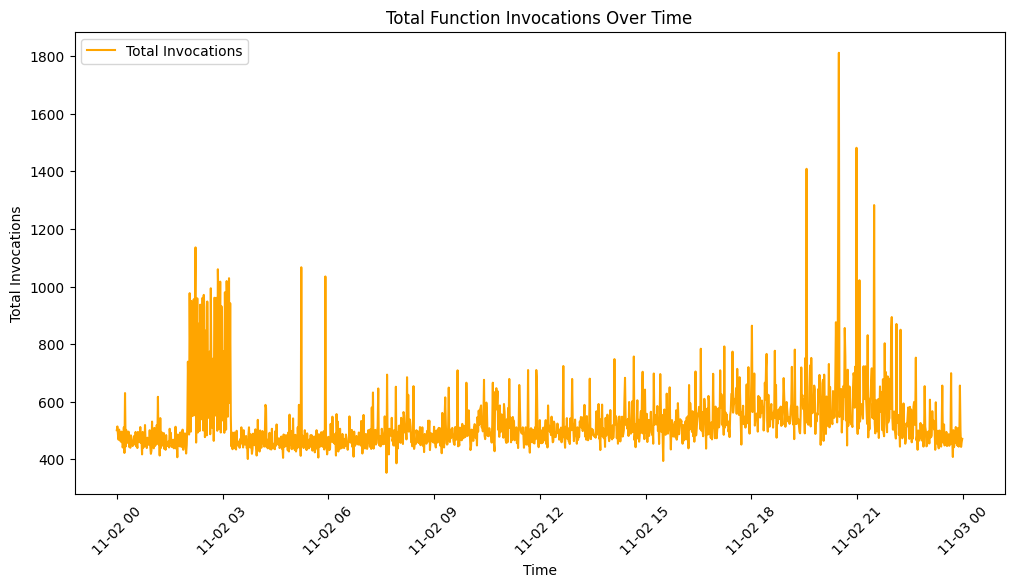

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['total_invocations'], label="Total Invocations", color='orange')
plt.xlabel("Time")
plt.ylabel("Total Invocations")
plt.title("Total Function Invocations Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Dataset Splitting



In [41]:
# Ensure time is the index
df.set_index('datetime', inplace=True)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)  # 80% data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

### Naive Baseline Model

In [42]:
naive_forecast = train['total_invocations'].iloc[-1]
naive_forecast_series = np.full(len(test), naive_forecast)

### Simple Exponential Smoothing

In [43]:
ses_model = SimpleExpSmoothing(train['total_invocations']).fit(smoothing_level=0.2, optimized=True) #  smoothing parameter, alpha set to 0.2

# Forecast for test period
ses_forecast = ses_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


### Holt’s Linear Trend Model

In [44]:
holt_model = Holt(train['total_invocations']).fit()
holt_forecast = holt_model.forecast(len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


### Holt-Winters (Triple Exponential Smoothing)

In [45]:
# applied Additive Seasonality because of summing up in the preprocessing part
hw_model = ExponentialSmoothing(train['total_invocations'], trend='add', seasonal='add', seasonal_periods=288).fit()
hw_forecast = hw_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


### ARIMA (AutoRegressive Integerated Moving Average)

### ADF test for determining d

In [46]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

time_series = df['total_invocations']
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print("Conclusion: The series is stationary (d=0).")
    else:
        print("Conclusion: The series is NOT stationary. Differencing required (d=1).")

# Run ADF test
adf_test(time_series)


ADF Statistic: -3.4551425963515072
p-value: 0.009216690282422129
Critical Values:
	1%: -3.434979825137732
	5%: -2.8635847436211317
	10%: -2.5678586114197954
Conclusion: The series is stationary (d=0).


In [47]:
# differencing to make double sure that data is stationary
diff_series = time_series.diff().dropna()

# Re-run ADF Test on differenced data
adf_test(diff_series)


ADF Statistic: -10.614031650660504
p-value: 5.73597624076468e-19
Critical Values:
	1%: -3.434979825137732
	5%: -2.8635847436211317
	10%: -2.5678586114197954
Conclusion: The series is stationary (d=0).


### PACF Plot for determining p

<Figure size 1200x500 with 0 Axes>

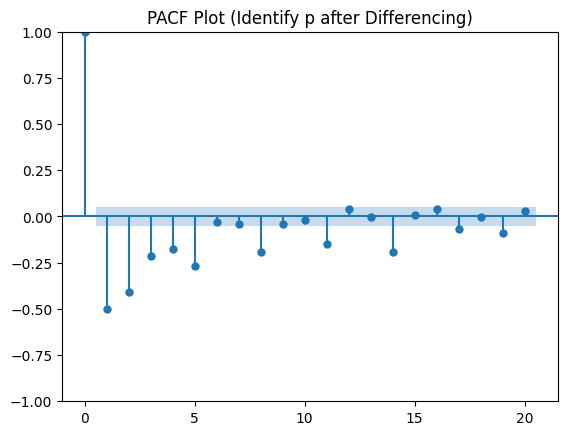

In [48]:
plt.figure(figsize=(12, 5))
plot_pacf(diff_series, lags=20)
plt.title("PACF Plot (Identify p after Differencing)")
plt.show()

p = 1 since the lag at 1 is largest spike

<Figure size 1200x500 with 0 Axes>

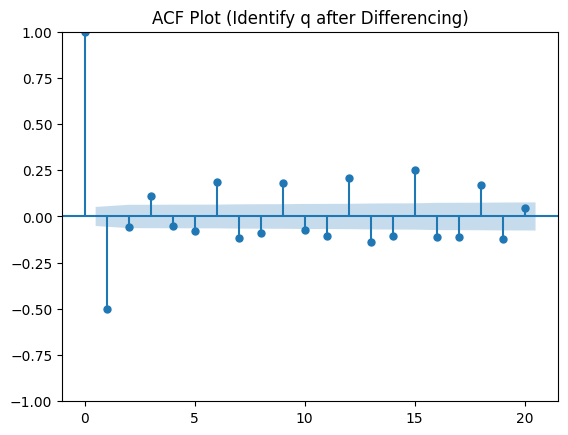

In [49]:
plt.figure(figsize=(12, 5))
plot_acf(diff_series, lags=20)
plt.title("ACF Plot (Identify q after Differencing)")
plt.show()


q =1 since q = 1 have largest spike

In [50]:
# Train ARIMA Model
arima_model = ARIMA(train['total_invocations'], order=(1,0,1)).fit()

# Forecast
arima_forecast = arima_model.forecast(len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

### Didn't use the VAR model since my dataset is Univariate inlcuding timestamp and total_invocations only. However for bonus points, another multivariate time series data is used.

### Functions that give you all the required performance metrics, MAE, RMSE, and MAPE

In [51]:
# Function to compute evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))  # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100  # Mean Absolute Percentage Error

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

### All Models Results

In [52]:
test['total_invocations'].size

288

In [53]:
model_results = {}
model_results["naive_forecast"] = evaluate_forecast(test['total_invocations'], naive_forecast_series) #Naive Forecast
model_results["ses_forecast"] = evaluate_forecast(test['total_invocations'], ses_forecast) # SES
model_results["holt_linear"] = evaluate_forecast(test['total_invocations'], holt_forecast) # Holt Linear Trend
model_results["holt_winters"] = evaluate_forecast(test['total_invocations'], hw_forecast) #Holt Winter
model_results["arima_forecast"] = evaluate_forecast(test['total_invocations'], arima_forecast) # ARIMA

In [54]:
results_df = pd.DataFrame(model_results).T

from IPython.display import display
display(results_df)

,MAE,RMSE,MAPE
naive_forecast,86.979167,161.954598,12.656594
ses_forecast,91.509000,153.387247,14.709435
holt_linear,89.586084,153.015790,14.231775
holt_winters,146.716804,190.252477,26.668826
arima_forecast,83.228087,157.832165,12.138456


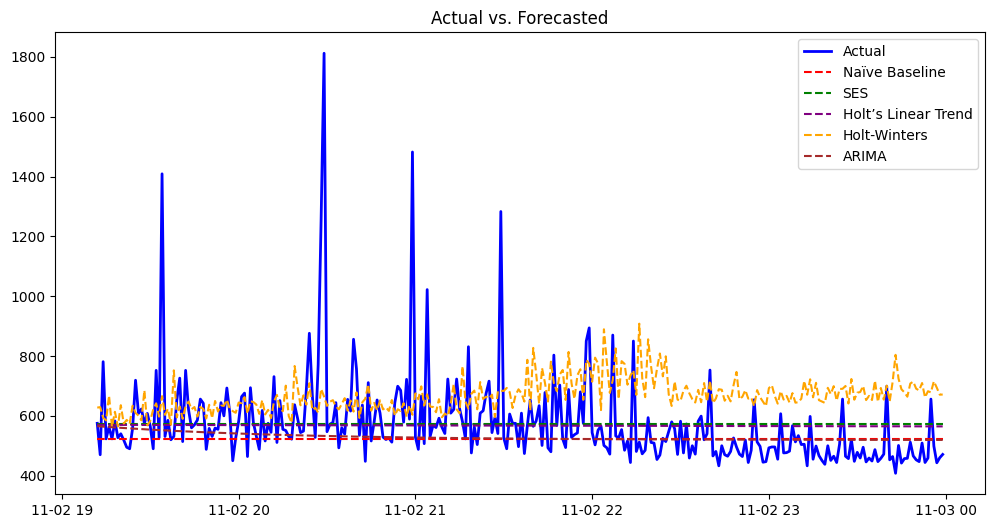

In [55]:
plt.figure(figsize=(12, 6))

# Actual Values
plt.plot(test.index, test, label="Actual", color='blue', linewidth=2)
# Forecasted values
plt.plot(test.index, naive_forecast_series, label="Naïve Baseline", linestyle="dashed", color='red')
plt.plot(test.index, ses_forecast, label="SES", linestyle="dashed", color='green')
plt.plot(test.index, holt_forecast, label="Holt’s Linear Trend", linestyle="dashed", color='purple')
plt.plot(test.index, hw_forecast, label="Holt-Winters", linestyle="dashed", color='orange')
plt.plot(test.index, arima_forecast, label="ARIMA", linestyle="dashed", color='brown')
plt.title("Actual vs. Forecasted")
plt.legend()

### Bonus Points Section

#Hyperparameter Tunning for SES model with different smoothing parameter

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init

   Alpha        MAE        RMSE       MAPE
0    0.1  90.840663  153.412693  14.557536
1    0.2  91.509000  153.387247  14.735840
2    0.3  91.461665  153.387809  14.723293
3    0.5  88.776193  153.814869  13.975088
4    0.7  86.315946  156.320999  13.074337
5    0.9  86.289539  160.387915  12.668996


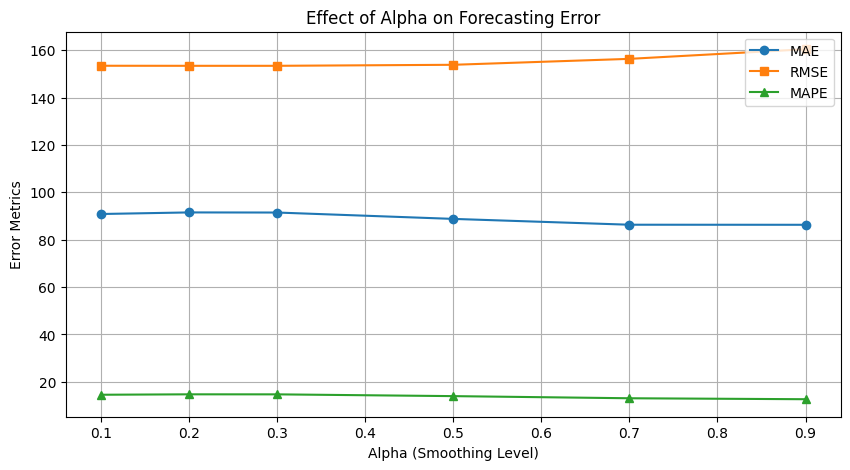

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# different smoothing parameter
alpha_values = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

results = []

for alpha in alpha_values:
    # model training
    ses_model = SimpleExpSmoothing(train['total_invocations']).fit(smoothing_level=alpha, optimized=False)
    ses_forecast = ses_model.forecast(len(test))

    # evaluation metric calculation
    mae = mean_absolute_error(test['total_invocations'], ses_forecast)
    rmse = np.sqrt(mean_squared_error(test['total_invocations'], ses_forecast))
    mape = np.mean(np.abs((test['total_invocations'] - ses_forecast) / test['total_invocations'])) * 100
    results.append({'Alpha': alpha, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['Alpha'], results_df['MAE'], marker='o', label="MAE")
plt.plot(results_df['Alpha'], results_df['RMSE'], marker='s', label="RMSE")
plt.plot(results_df['Alpha'], results_df['MAPE'], marker='^', label="MAPE")
plt.xlabel("Alpha (Smoothing Level)")
plt.ylabel("Error Metrics")
plt.title("Effect of Alpha on Forecasting Error")
plt.legend()
plt.grid(True)
plt.show()


### VAR MODEL on multivariate time series data

In [57]:
# Reading the multivariate time series data
file_path = "multivariate.csv"
df = pd.read_csv(file_path)

In [58]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Data is NOT stationary (Differencing needed).")
    else:
        print("Data is stationary.")

check_stationarity(df['total_cpu'])
check_stationarity(df['total_requests'])


ADF Statistic: -0.12409509876684047
p-value: 0.9469850527732788
Data is NOT stationary (Differencing needed).
ADF Statistic: -0.8226803149416289
p-value: 0.8123689526568012
Data is NOT stationary (Differencing needed).


In [59]:
# applying differencing to make data stationary
df['cpu_usage_diff'] = df['total_cpu'].diff().dropna()
df['requests_diff'] = df['total_requests'].diff().dropna()


In [60]:
df_var = df[['cpu_usage_diff', 'requests_diff']]
df_var.fillna(method="ffill", inplace=True)  # Forward fill
df_var.dropna(inplace=True)

scaler = MinMaxScaler()
df_var_scaled = pd.DataFrame(scaler.fit_transform(df_var), columns=df_var.columns, index=df_var.index)

model = VAR(df_var_scaled)
var_result = model.fit(ic='aic')

# Forecast
forecast = var_result.forecast(df_var_scaled.values[-var_result.k_ar:], steps=10)
print(forecast)


<ipython-input-60-35746c327254>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_var.fillna(method="ffill", inplace=True)  # Forward fill
<ipython-input-60-35746c327254>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var.fillna(method="ffill", inplace=True)  # Forward fill
<ipython-input-60-35746c327254>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var.dropna(inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, fo

[[0.62505723 0.4165422 ]
 [0.62695143 0.40471361]
 [0.63383261 0.41143753]
 [0.63043506 0.41796858]
 [0.62799487 0.42599985]
 [0.63411857 0.42792475]
 [0.62457067 0.4196459 ]
 [0.63085488 0.41666376]
 [0.63252355 0.41698311]
 [0.632482   0.43606702]]


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual_values = df_var.values[-10:]

mae = mean_absolute_error(actual_values, forecast)
rmse = np.sqrt(mean_squared_error(actual_values, forecast))
mape = np.mean(np.abs((actual_values - forecast) / actual_values)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MAE: 20918.822797040182
RMSE: 49719.22893583113
MAPE: 99.47660348024307%
